# Inception

### Kaggle score: --

### References:
1. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import gc

import cv2

### Run name

In [3]:
project_name = 'Digit_Recognizer'
step_name = 'Inception'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: Digit_Recognizer_Inception_20180113_164926


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\ref\Kaggle\digit-recognizer\input
log_path: D:\ref\Kaggle\digit-recognizer\log
model_path: D:\ref\Kaggle\digit-recognizer\model
output_path: D:\ref\Kaggle\digit-recognizer\output


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

In [6]:
def show_data_images(rows, fig_column, y_data, *args):
    columns = len(args)
    figs, axes = plt.subplots(rows, columns, figsize=(rows, fig_column*columns))
    print(axes.shape)  
    for i, ax in enumerate(axes):
        y_data_str = ''
        if type(y_data) != type(None):
            y_data_str =  '_' + str(y_data[i])
        ax[0].set_title('28x28' + y_data_str)
        for j, arg in enumerate(args):
            ax[j].imshow(arg[i])

### Load data

In [7]:
train_file = os.path.join(input_path, 'train.csv')
test_file = os.path.join(input_path, 'test.csv')

In [8]:
%%time
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_data = raw_data[:,1:]
y_data = raw_data[:,0]

x_test = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')

describe(x_data)
describe(y_data)
describe(x_test)

(42000, 784) 0 255 112
(42000,) 0 9 96
(28000, 784) 0 255 112
Wall time: 26.4 s


In [9]:
x_data = x_data/255.
x_test = x_test/255.

describe(x_data)
describe(x_test)

x_data = x_data.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

describe(x_data)
describe(x_test)

(42000, 784) 0.0 1.0 263424112
(28000, 784) 0.0 1.0 175616112
(42000, 28, 28, 1) 0.0 1.0 144
(28000, 28, 28, 1) 0.0 1.0 144


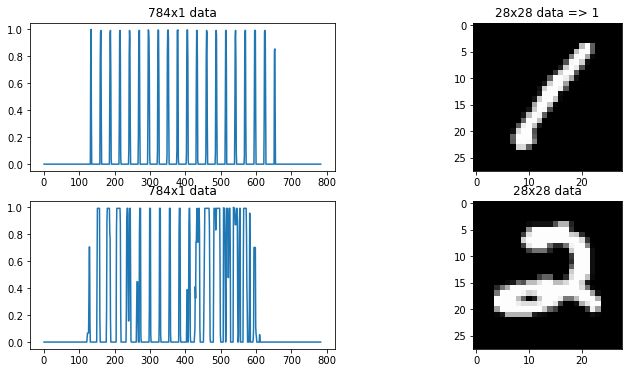

In [10]:
index = 0
fig, ax = plt.subplots(2, 2, figsize=(12,6))
ax[0, 0].plot(x_data[index].reshape(784,))
ax[0, 0].set_title('784x1 data')
ax[0, 1].imshow(x_data[index].reshape(28,28), cmap='gray')
ax[0, 1].set_title('28x28 data => ' + str(y_data[index]))
                 
ax[1, 0].plot(x_test[index].reshape(784,))
ax[1, 0].set_title('784x1 data')
ax[1, 1].imshow(x_test[index].reshape(28,28), cmap='gray')
ax[1, 1].set_title('28x28 data')

In [11]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
print(y_data[0])
y_data = to_categorical(y_data)
#example:
print(y_data[0])

Using TensorFlow backend.


1
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.05, random_state=31)
describe(x_train)
describe(x_val)
describe(y_train)
describe(y_val)

(39900, 28, 28, 1) 0.0 1.0 250252944
(2100, 28, 28, 1) 0.0 1.0 13171344
(39900, 10) 0.0 1.0 3192112
(2100, 10) 0.0 1.0 168112


### Build model

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

In [14]:
def build_model():
    bn_model = 0
    p_activation = "relu"
    input_1 = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name="input")
    
    img_1 = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same')(input_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
    
    img_2 = Conv2D(64, kernel_size = (2,2), activation=p_activation, padding='same')(input_1)
    img_2 = BatchNormalization()(img_2)
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.4)(img_2)
    
    img_3 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same')(input_1)
    img_3 = BatchNormalization()(img_3)
    img_3 = MaxPooling2D((2,2)) (img_3)
    img_3 = Dropout(0.4)(img_3)
    
    img_5 = Conv2D(64, kernel_size = (5,5), activation=p_activation, padding='same')(input_1)
    img_5 = BatchNormalization()(img_5)
    img_5 = MaxPooling2D((2,2)) (img_5)
    img_5 = Dropout(0.4)(img_5)
    
    img_10 = Conv2D(64, kernel_size = (10,10), activation=p_activation, padding='same')(input_1)
    img_10 = BatchNormalization()(img_10)
    img_10 = MaxPooling2D((2,2)) (img_10)
    img_10 = Dropout(0.4)(img_10)
    
    img_20 = Conv2D(64, kernel_size = (20,20), activation=p_activation, padding='same')(input_1)
    img_20 = BatchNormalization()(img_20)
    img_20 = MaxPooling2D((2,2)) (img_20)
    img_20 = Dropout(0.4)(img_20)
    
    concat_layer = (Concatenate()([img_1, img_2, img_3, img_5, img_10, img_20]))
#############################################################################################
    img_1 = Conv2D(64, kernel_size = (1,1), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
    
    img_2 = Conv2D(64, kernel_size = (2,2), activation=p_activation, padding='same')(concat_layer)
    img_2 = BatchNormalization()(img_2)
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.4)(img_2)
    
    img_3 = Conv2D(64, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_3 = BatchNormalization()(img_3)
    img_3 = MaxPooling2D((2,2)) (img_3)
    img_3 = Dropout(0.4)(img_3)
    
    img_5 = Conv2D(64, kernel_size = (5,5), activation=p_activation, padding='same')(concat_layer)
    img_5 = BatchNormalization()(img_5)
    img_5 = MaxPooling2D((2,2)) (img_5)
    img_5 = Dropout(0.4)(img_5)
    
    img_10 = Conv2D(64, kernel_size = (10,10), activation=p_activation, padding='same')(concat_layer)
    img_10 = BatchNormalization()(img_10)
    img_10 = MaxPooling2D((2,2)) (img_10)
    img_10 = Dropout(0.4)(img_10)
    
    img_20 = Conv2D(64, kernel_size = (20,20), activation=p_activation, padding='same')(concat_layer)
    img_20 = BatchNormalization()(img_20)
    img_20 = MaxPooling2D((2,2)) (img_20)
    img_20 = Dropout(0.4)(img_20)
    
    concat_layer = (Concatenate()([img_1, img_2, img_3, img_5, img_10, img_20]))
#############################################################################################
    img_1 = Conv2D(256, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(256, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
#############################################################################################
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
#############################################################################################

    img_1 = GlobalMaxPooling2D() (img_1)

    dense_ayer = Dense(1024, activation=p_activation)(img_1)
#     dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.4)(dense_ayer)
    dense_ayer = Dense(1024, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.4)(dense_ayer)
    dense_ayer = Dense(128, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.4)(dense_ayer)
    output = Dense(10, activation='softmax')(dense_ayer)

    model = Model(input_1, output)
    
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
    return model

In [15]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   128         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 64)   320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 64)   640         input[0][0]                      
__________________________________________________________________________________________________
conv2d_4 (

In [16]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [17]:
def get_lr(x):
    lr = round(1e-4 * 0.995 ** x, 6)
    if lr < 5e-5:
        lr = 5e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\ref\Kaggle\digit-recognizer\log\Digit_Recognizer_Inception_20180113_164926


In [ ]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    rotation_range = 20,
    height_shift_range = 0.2,
    width_shift_range = 0.2
)

val_datagen = ImageDataGenerator()

In [ ]:
%%time
batch_size = 128
steps_per_epoch = x_train.shape[0] / batch_size
hist = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size, seed=2018),
    steps_per_epoch=steps_per_epoch,
    epochs=100, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=[annealer],
    max_queue_size=256,
    workers=32,
    validation_steps=1000,
    validation_data=val_datagen.flow(x_val, y_val, batch_size=32, seed=2018)
)

0.0001  Epoch 1/100
312/311 [==============================] - 91s 291ms/step - loss: 2.2876 - acc: 0.1807 - val_loss: 10.7214 - val_acc: 0.1138
0.0001  Epoch 2/100
312/311 [==============================] - 86s 276ms/step - loss: 1.7864 - acc: 0.3293 - val_loss: 12.4348 - val_acc: 0.1181
9.9e-05  Epoch 3/100
312/311 [==============================] - 87s 278ms/step - loss: 0.9414 - acc: 0.6756 - val_loss: 0.7525 - val_acc: 0.7881
9.9e-05  Epoch 4/100
312/311 [==============================] - 86s 276ms/step - loss: 0.4395 - acc: 0.8707 - val_loss: 0.2582 - val_acc: 0.9348
9.8e-05  Epoch 5/100
312/311 [==============================] - 86s 275ms/step - loss: 0.2943 - acc: 0.9189 - val_loss: 0.1305 - val_acc: 0.9633
9.8e-05  Epoch 6/100
312/311 [==============================] - 86s 275ms/step - loss: 0.2336 - acc: 0.9362 - val_loss: 0.0753 - val_acc: 0.9786
9.7e-05  Epoch 7/100
312/311 [==============================] - 86s 275ms/step - loss: 0.2010 - acc: 0.9436 - val_loss: 0.0479 - v

In [ ]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

In [ ]:
final_acc_str = '{0:0>4}'.format(int(final_acc*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

In [ ]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [ ]:
saveModel(model, run_name_acc)

In [ ]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

## Predict

In [ ]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

In [ ]:
y_hat = model.predict(x_test, batch_size=64)

In [ ]:
y_pred = np.argmax(y_hat,axis=1)

In [ ]:
with open(pred_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

In [ ]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

In [ ]:
print(run_name_acc)